In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 7.9MB/s 


In [5]:
!pip install keras_vggface keras_applications

     |████████████████████████████████| 51kB 4.5MB/s 


In [6]:
!mkdir -p ~/.kaggle

In [7]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [8]:
!kaggle datasets list -s faces

ref                                              title                                      size  lastUpdated          downloadCount  
-----------------------------------------------  ----------------------------------------  -----  -------------------  -------------  
kostastokis/simpsons-faces                       Simpsons Faces                            442MB  2018-09-28 17:38:04           5051  
soumikrakshit/anime-faces                        Anime Faces                               441MB  2019-05-16 10:38:47           4000  
ashwingupta3012/human-faces                      Human Faces                                 2GB  2020-09-21 04:09:12            863  
andrewmvd/animal-faces                           Animal Faces                              696MB  2020-05-22 06:49:01           1353  
selfishgene/youtube-faces-with-facial-keypoints  YouTube Faces With Facial Keypoints          0B  2020-05-25 22:53:33           7209  
dansbecker/5-celebrity-faces-dataset             5 Cele

In [9]:
!kaggle datasets download -d dansbecker/5-celebrity-faces-dataset

 99% 5.00M/5.03M [00:00<00:00, 26.0MB/s]
100% 5.03M/5.03M [00:00<00:00, 24.7MB/s]


In [10]:
!ls

5-celebrity-faces-dataset.zip  drive  sample_data


In [11]:
!unzip 5-celebrity-faces-dataset.zip

Archive:  5-celebrity-faces-dataset.zip
  inflating: data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg  
  inflating: data/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  
  inflating: data/train/ben_afflek/httptrwebimgacstanetcxbdddmediasnmediajpg.jpg  
  inflating: data/train/ben_afflek/httpwwwaceshowbizcomimagesphotobenaffleckjp

In [12]:
from mtcnn.mtcnn import MTCNN
import cv2
import numpy as np
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine 

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [13]:
image = cv2.imread('data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')

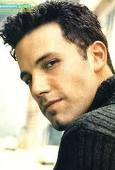

In [14]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [15]:
detector = MTCNN()

faces = detector.detect_faces(image)
for face in faces:
  print(face)

{'box': [20, 35, 70, 88], 'confidence': 0.9996923208236694, 'keypoints': {'left_eye': (29, 73), 'right_eye': (54, 63), 'nose': (37, 90), 'mouth_left': (42, 108), 'mouth_right': (63, 100)}}


In [16]:
def create_bbox(image):
  faces = detector.detect_faces(image)
  get_boundingbox = faces[0]['box']
  cv2.rectangle(image,
                (get_boundingbox[0], get_boundingbox[1]),
                (get_boundingbox[0]+get_boundingbox[2],get_boundingbox[1] + get_boundingbox[3]),
                (0,155,255),
                2)
  return image

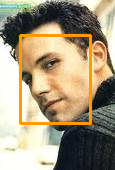

In [17]:
cv2_imshow(create_bbox(image))

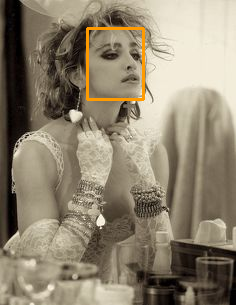

In [18]:
marked_image = create_bbox(cv2.imread('data/train/madonna/httpssmediacacheakpinimgcomxfeebfdccajpg.jpg'))
cv2_imshow(marked_image)

In [19]:
def extract_face(image, resize=(224,224)):
  image = cv2.imread(image)

  faces = detector.detect_faces(image)
  x1, y1, width, height = faces[0]['box']
  x2, y2 = x1 + width, y1 + height

  face_boundary = image[y1:y2, x1:x2]
  face_image = cv2.resize(face_boundary,resize)

  return face_image

   

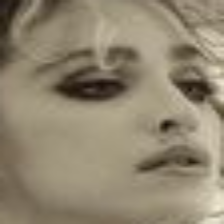

In [20]:
face_image = extract_face('data/train/madonna/httpssmediacacheakpinimgcomxfeebfdccajpg.jpg')
cv2_imshow(face_image)

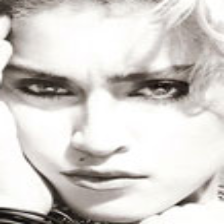

In [21]:
face_image = extract_face('data/val/madonna/httpassetsrollingstonecomassetsimagesalbumreviewaffaceabdcccaeedjpg.jpg')
cv2_imshow(face_image)

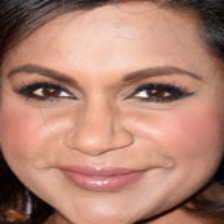

In [22]:
face_image = extract_face('data/train/mindy_kaling/httpwwwpictureszimbiocomgiMindyKalingLkvEhTwDeJmjpg.jpg')
cv2_imshow(face_image)

In [23]:
def get_embeddings(faces):
  face = np.asarray(faces, 'float32')
  face = preprocess_input(face, version=2)
  model = VGGFace(model='resnet50',include_top=False, input_shape=(224,224,3),pooling='avg')
  return model.predict(face)

In [24]:
def get_similarity(faces):
  embeddings = get_embeddings(faces)

  score = cosine(embeddings[0],embeddings[1])
  print(embeddings[0])

  if score <= 0.5:
    return "Face Matched", score

  return "Face Not Matched", score

In [25]:
faces = [extract_face(image) for image in ['data/train/madonna/httpssmediacacheakpinimgcomxfeebfdccajpg.jpg','data/val/madonna/httpassetsrollingstonecomassetsimagesalbumreviewaffaceabdcccaeedjpg.jpg']]

In [26]:
get_similarity(faces)

94699520/94694792 [==============================] - 2s 0us/step
[0.23286961 0.36629772 0.70134616 ... 0.15583594 5.626234   0.        ]


('Face Matched', 0.4418410658836365)

In [27]:
faces = [extract_face(image) for image in ['data/val/madonna/httpassetsrollingstonecomassetsimagesalbumreviewaffaceabdcccaeedjpg.jpg','data/train/mindy_kaling/httpwwwpictureszimbiocomgiMindyKalingLkvEhTwDeJmjpg.jpg']]

In [28]:
get_similarity(faces)

[0.        3.4173868 0.        ... 0.6377015 6.9879894 0.       ]


('Face Not Matched', 0.6494751274585724)

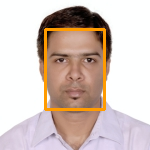

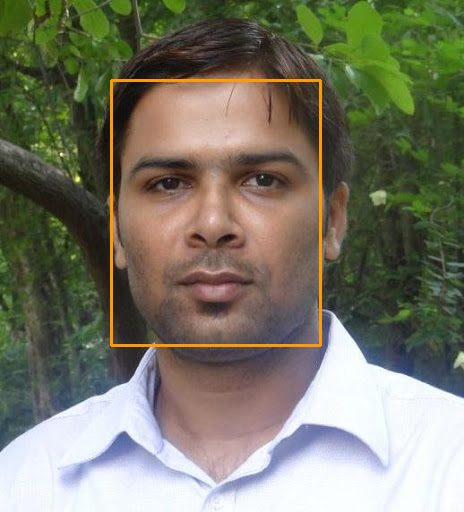

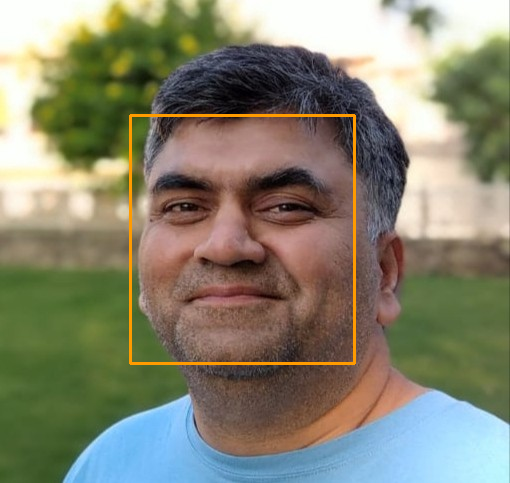

In [47]:
Saurabh_1 = cv2.imread('/content/drive/MyDrive/Saurabh-Tiwari-1.jpg')
Saurabh_2 = cv2.imread('/content/drive/MyDrive/Saurabh-Tiwari-2.jpg')
GaganGarg = cv2.imread('/content/drive/MyDrive/Gagan garg.jpeg')
detector = MTCNN()
list = [Saurabh_1,Saurabh_2,GaganGarg]
for images in list:
  faces = detector.detect_faces(images)
  cv2_imshow(create_bbox(images))
  





In [46]:
faces = [extract_face(image) for image in ['/content/drive/MyDrive/Saurabh-Tiwari-1.jpg','/content/drive/MyDrive/Saurabh-Tiwari-2.jpg']]
get_similarity(faces)

[0.         0.05929922 0.01374079 ... 0.         0.09553739 0.46589446]


('Face Matched', 0.17989641427993774)

In [48]:
faces = [extract_face(image) for image in ['/content/drive/MyDrive/Saurabh-Tiwari-1.jpg','/content/drive/MyDrive/Gagan garg.jpeg']]
get_similarity(faces)

[0.         0.05929922 0.01374079 ... 0.         0.09553739 0.46589446]


('Face Not Matched', 0.7500176280736923)